### Analysis of game and reward + prediction


#### Import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import HTML, display

import re
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split as tts 
from tensorflow.keras.losses import mse, mean_absolute_error
from tensorflow.keras.optimizers import RMSprop, Adadelta


/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/pyth

In [192]:
def build_formula(target, cols):
    
    f = target + " ~ "
    f += " + ".join(map(lambda x: "C(" + x +")" , cols))
    
    return f


def compute_pseudo_r_squared(mod):
    return 1 - mod.deviance/mod.null_deviance


def catch_card(xx):
    try:
        card = re.split(r'\)',re.split(r'\(',xx)[1])[0].split('_')
    except:
        card = ["intercept", "intercept", "intercept"]
        
    return card

In [193]:
def get_results(model, color = 'rgb(158, 202, 225)'):
    
    results = model.conf_int()
    results.columns = ["coef_inf","coef_sup"]
    results["coef "]= model.params
    results["p_value"] = model.pvalues
    results["color"] = color
    results["card"] = results.index.map(catch_card)
    results[["is_atout", "value", "player"]] = results["card"].apply(pd.Series)
    
    results["is_atout"] = results["is_atout"]=="atout"
    del results["card"]
    return results

def get_style_for_results(results):
    """
    get style to highlight the significant values of a model's results 
    
    Args :
        df (dataframe) : model'results
            
    Returns : (df) : return a df with the styles to apply
    """
    c1 = 'background-color: #80E37C'
    c2 = '' 
    
    #condition to be green
    mask = results['p_value'] < 0.05
    
    #DataFrame with same index and columns names as original filled red color
    df1 =  pd.DataFrame(c2, index=results.index, columns=results.columns)
    
    #modify values of df1 column by boolean mask
    df1.loc[mask, ["coef_inf","coef_sup"]] = c1
    return df1


def get_results_formated(model, caption = "", color= "rgb(158,202,225)"):
    """
    highlights the significant values of a model's results 
    
    Args :
        model (model) : fitted model
        caption (str) : text describing the results (optional)
            
    Returns : (df with style) : return a stylized df
    """
    results = get_results(model, color = color)
    
    return results.style.apply(get_style_for_results, axis=None)\
           .set_caption(caption)

### Load data

In [203]:
data = pd.read_csv('data/hands_and_reward.csv')
data = data.drop("Unnamed: 0", axis=1)


suit = ["atout", "na1", "na2", "na3"]
cards = ["7", "8", "9", "10", "jack", "queen", "king", "as"]
players = ["p1", "p2"]
data.columns = [(suit*2)[x//8]+"_"+cards[x%8]+"_"+players[x//32] for x in range(64)] + ["total_reward"]

In [204]:
data.head()

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na1_7_p1,na1_8_p1,...,na2_as_p2,na3_7_p2,na3_8_p2,na3_9_p2,na3_10_p2,na3_jack_p2,na3_queen_p2,na3_king_p2,na3_as_p2,total_reward
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,111.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,32.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,68.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,64.0


**Let's check that the data is centered in 81, and in the intervale [0, 162]**

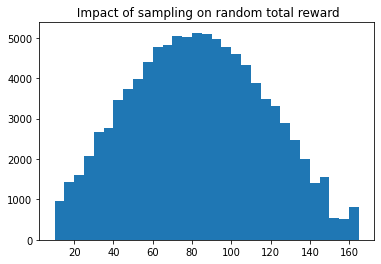

count    100000.000000
mean         81.170100
std          35.247125
min           0.000000
25%          55.000000
50%          81.000000
75%         107.000000
max         162.000000
Name: total_reward, dtype: float64

In [205]:
plt.hist(data["total_reward"], bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.title(" Impact of sampling on random total reward")
plt.show()

data["total_reward"].describe()

# Build formula

**We'll start by training a linear model, to check if card have a value that is linked to its rank and its suit:**

We suppose that all the cards are independants

In [206]:
formula = build_formula("total_reward", cols = np.concatenate([data.columns[:-1]]).tolist())
formula

'total_reward ~ C(atout_7_p1) + C(atout_8_p1) + C(atout_9_p1) + C(atout_10_p1) + C(atout_jack_p1) + C(atout_queen_p1) + C(atout_king_p1) + C(atout_as_p1) + C(na1_7_p1) + C(na1_8_p1) + C(na1_9_p1) + C(na1_10_p1) + C(na1_jack_p1) + C(na1_queen_p1) + C(na1_king_p1) + C(na1_as_p1) + C(na2_7_p1) + C(na2_8_p1) + C(na2_9_p1) + C(na2_10_p1) + C(na2_jack_p1) + C(na2_queen_p1) + C(na2_king_p1) + C(na2_as_p1) + C(na3_7_p1) + C(na3_8_p1) + C(na3_9_p1) + C(na3_10_p1) + C(na3_jack_p1) + C(na3_queen_p1) + C(na3_king_p1) + C(na3_as_p1) + C(atout_7_p2) + C(atout_8_p2) + C(atout_9_p2) + C(atout_10_p2) + C(atout_jack_p2) + C(atout_queen_p2) + C(atout_king_p2) + C(atout_as_p2) + C(na1_7_p2) + C(na1_8_p2) + C(na1_9_p2) + C(na1_10_p2) + C(na1_jack_p2) + C(na1_queen_p2) + C(na1_king_p2) + C(na1_as_p2) + C(na2_7_p2) + C(na2_8_p2) + C(na2_9_p2) + C(na2_10_p2) + C(na2_jack_p2) + C(na2_queen_p2) + C(na2_king_p2) + C(na2_as_p2) + C(na3_7_p2) + C(na3_8_p2) + C(na3_9_p2) + C(na3_10_p2) + C(na3_jack_p2) + C(na3_quee

## Create linear model and get first results

In [ ]:
mod = smf.glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
print("pseudo_R2: ", compute_pseudo_r_squared(mod))

In [ ]:
formated_results = get_results_formated(mod)

As game and playing are random and as non atout suits are playing a symetrical role, we can average the coef value directly

In [ ]:
average_coef = formated_results.data.groupby(["is_atout", "value"]).agg({"p_value": "max",
                                                                         "coef_inf":"mean",
                                                                         "coef_sup":"mean"})

In [ ]:
(average_coef.style
            .apply(get_style_for_results, axis=None)
            .set_caption(""))

### First neural network model with convolutions taking two players games

In [211]:
# Creatgin class_weigth dict to penalize extreme values
# thresholds = [30, 50, 80, 100, 110]
class_weights = {}
for i in range(163):
    i = float(i)
    if i > 110:
        class_weights[i] = 4
    elif (i <= 50) | (i > 100):
        class_weights[i] = 3
    elif (i > 82) | (i <60):
        class_weights[i] = 2
    else:
        class_weights[i] = 1

In [212]:
def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu', input_shape=(64, 1)))
    model.add(layers.AveragePooling1D(pool_size = 4, strides=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=8, kernel_size=4, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=4, kernel_size=2, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(64,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

loss = mse

model = build_cnn_model()
model.compile(optimizer="adam", loss=loss)

model_class_weight = build_cnn_model()
model_class_weight.compile(optimizer="adam", loss=loss)

relu_class_weigth_model = build_model()
relu_class_weigth_model.compile(optimizer="adam", loss=loss)

relu_model = build_model()
relu_model.compile(optimizer="adam", loss=loss)

In [213]:
xtrain, xtest, ytrain, ytest = tts(data[data.columns[:-1]].values, data.total_reward, test_size=0.2, random_state=4)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [ ]:
epochs = 50

model.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest))

model_class_weight.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest), class_weight=class_weights)

relu_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest))

relu_class_weigth_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest), class_weight=class_weights)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 7s 84us/sample - loss: 2240.5947 - val_loss: 1298.6195
Epoch 2/50
80000/80000 [==============================] - 4s 50us/sample - loss: 1035.6216 - val_loss: 1110.3032
Epoch 3/50
80000/80000 [==============================] - 4s 47us/sample - loss: 963.9361 - val_loss: 968.6972
Epoch 4/50
80000/80000 [==============================] - 4s 48us/sample - loss: 922.3071 - val_loss: 916.7928
Epoch 5/50
80000/80000 [==============================] - 4s 46us/sample - loss: 888.5508 - val_loss: 873.9589
Epoch 6/50
80000/80000 [==============================] - 4s 45us/sample - loss: 867.6814 - val_loss: 861.2080
Epoch 7/50
80000/80000 [==============================] - 4s 45us/sample - loss: 854.6988 - val_loss: 849.4761
Epoch 8/50
80000/80000 [==============================] - 4s 53us/sample - loss: 846.1947 - val_loss: 856.1860
Epoch 9/50
80000/80000 [==============================] - 

80000/80000 [==============================] - 4s 48us/sample - loss: 2114.1343 - val_loss: 855.3693
Epoch 24/50
80000/80000 [==============================] - 4s 48us/sample - loss: 2102.1229 - val_loss: 871.7902
Epoch 25/50
80000/80000 [==============================] - 4s 48us/sample - loss: 2102.3861 - val_loss: 786.0623
Epoch 26/50
80000/80000 [==============================] - 4s 48us/sample - loss: 2102.3413 - val_loss: 1077.5386
Epoch 27/50
80000/80000 [==============================] - 4s 49us/sample - loss: 2095.1045 - val_loss: 1844.5759
Epoch 28/50
80000/80000 [==============================] - 4s 46us/sample - loss: 2088.2904 - val_loss: 785.2024
Epoch 29/50
80000/80000 [==============================] - 4s 47us/sample - loss: 2094.8655 - val_loss: 762.6303
Epoch 30/50
80000/80000 [==============================] - 4s 47us/sample - loss: 2084.7148 - val_loss: 754.7440
Epoch 31/50
80000/80000 [==============================] - 4s 53us/sample - loss: 2081.2614 - val_loss: 78

80000/80000 [==============================] - 1s 15us/sample - loss: 487.5843 - val_loss: 614.4159
Epoch 46/50
80000/80000 [==============================] - 1s 15us/sample - loss: 484.0947 - val_loss: 614.3510
Epoch 47/50
80000/80000 [==============================] - 1s 15us/sample - loss: 479.9792 - val_loss: 628.5563
Epoch 48/50
80000/80000 [==============================] - 1s 15us/sample - loss: 476.0997 - val_loss: 626.4043
Epoch 49/50
80000/80000 [==============================] - 1s 15us/sample - loss: 474.6953 - val_loss: 622.9332
Epoch 50/50
80000/80000 [==============================] - 1s 17us/sample - loss: 470.3903 - val_loss: 628.0475
Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 4s 44us/sample - loss: 4323.5630 - val_loss: 602.9214
Epoch 2/50
80000/80000 [==============================] - 2s 28us/sample - loss: 1625.5582 - val_loss: 598.8293
Epoch 3/50
80000/80000 [==============================] - 2s 27us/

In [ ]:
x1 = sorted(np.absolute(ytest-model_class_weight.predict(xtest).reshape(ytest.shape)))
x2 = sorted(np.absolute(ytest-model.predict(xtest).reshape(ytest.shape)))
x3 = sorted(np.absolute(ytest-relu_class_weigth_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))
x4 = sorted(np.absolute(ytest-relu_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))

plt.figure(figsize = (15, 15))
plt.subplot(2,2,1)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,2)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,3)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model_class_weight.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model with class wheighting - bins")
plt.legend()

plt.subplot(2,2,4)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_class_weigth_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model with class wheighting - bins")
plt.legend()
plt.show()

In [ ]:
kwargs = dict(histtype='step', bins=np.arange(0, 80, 10))

plt.figure(figsize=(10,10))
plt.hist(x1, label = "cnn cw", **kwargs)
plt.hist(x2,label = "cnn", **kwargs)
plt.hist(x3,label = "relu cw", **kwargs)
plt.hist(x4,label = "relu", **kwargs)
plt.legend()
plt.show()